## 협업 필터링 (Collaborative Filtering) 구현하기 

이번 수업에서는 추천 시스템(Recommender System)에서 널리 사용되는 협업 필터링(이하 Collaborative Filtering)의 원리를 알아보고 이를 구현해보겠습니다. 추천 시스템은 사용자(이하 사용자)가 특정 물건이나 서비스(이하 상품)에 대한 선호 여부나 선호도를 예측하는 시스템을 의미합니다. 추천 시스템은 아마존과 같은 이커머스부터 페이스북과 같은 SNS, 유튜브, 넷플릭스 등과 같은 동영상 플랫폼까지 다양한 분야에서 두루 활용되고 있습니다.

Collaborative Filtering에는 사용자에게 상품을 추천을 방법이 크게 두 가지가 있습니다. 1. 사용자가 선호하는 상품과 유사한 다른 상품 을 추천(상품 기반)하거나 2. 사용자와 유사한 다른 사용자가 선호하는 상품을 추천(사용자 기반)합니다. 사용자 기반 기법이 먼저 등장한 전통적인 알고리즘이고 상품 기반 방식은 이후 아마존(Amazon)이 제안한 기법입니다. 상품 기반 기법이 더 많은 기업들에서 사용되고 있다고 합니다.

사용자 기반 방식이 갖는 문제는 우선 **1. 계산 복잡성 문제**와 **2. 희소성 문제**가 대표적입니다. 아마존과 같이 거대 이커머스 회사들은 수백만 명의 사용자와 수백만 개의 상품을 관리해야하는데 사용자 기반 방식을 사용하는 경우 사용자가 추가될 때마다 나머지 모든 사용자와의 유사도를 연산해야한다는 문제점이 있습니다. 상품 기반 방식을 사용하는 경우에 미리 구해 놓은 상품 간 유사도를 활용할 수 있기 때문에 이러한 문제점이 어느 정도 해결됩니다! 물론 상품 기반 방식도 상품과 사용자가 계속 추가되므로 일정 기간마다 새롭게 유사도를 구해야하지만 사용자 기반 방식보다는 훨씬 계산 복잡성이 작습니다. 그리고 계산 복잡성 문제가 해결되는 대신 이 거대한 행렬을 저장할 공간이 따로 확보되어야한다는 점을 굳이 단점으로 뽑을 수 있습니다. 데이터 희소성 문제는 협업 필터링 알고리즘의 본질적인 취약한 점이지만 사용자가 많은 상품을 평가한 경우는 보통 없어서 이런 경우 사용자간의 유사도를 연산하는 것 자체가 어렵기 때문에 보통 사용자 기반 방식이 더 취약합니다.


상품 / 사용자 기반 기법은 전반적으로 다음과 같은 흐름으로 동작합니다.

1. 우선 사용자 $u$가 내릴 상품 $i$에 대한 평점(rating)을 추정하고자 합니다. 상품 $i$ / 사용자 $u$와 나머지 모든 상품 / 사용자의 유사도를 연산합니다.
2. 유사도가 높은 k개 상품 / 사용자를 선택합니다. 이를 이웃이라고 부르겠습니다.
3. 상품 기반 혹은 사용자 기반 기법에 따라 아래 단계를 수행하며 평점을 예측합니다.
    - 상품 기반 : 이웃 상품에 내린 사용자 $u$의 평점(rating)을 상품 $i$와의 유사도에 따라 가중 평균을 구합니다. 
    - 사용자 기반 : 이웃 사용자가 상품 $i$에 내린 평점(rating)을 사용자 $u$와의 유사도에 따라 가중 평균을 구합니다.
4. 아직 평점(rating)이 없는 항목에 대해 모든 평점(rating)을 예측합니다. 평점(rating) 예측 값 상위 n개 상품을 추천합니다.

이러한 머신러닝 알고리즘을 잘 이해하는 방법은, 알고리즘을 파이썬과 같은 프로그래밍 언어로 직접 구현해보는 것입니다. 그러므로 이번 시간에는 주어진 데이터와 문제를 Collaborative Filtering을 활용하여 풀되, [surprise](http://surpriselib.com/)와 같은 추천 시스템 패키지를 사용하지 않고 파이썬으로 직접 구현해서 풀어보는 시간을 가질 것입니다.

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame

### Generate DataSet

In [2]:
data = pd.read_csv('../data/ratings.csv')

In [3]:
data

,사람,책,평점
0,민지,백설공주,5.0
1,민지,신데렐라,4.0
2,민지,어린왕자,1.0
3,민지,흥부전,3.0
4,현우,노인과바다,3.0
5,현우,신데렐라,2.0
6,현우,콩쥐팥쥐,1.0
7,현우,흥부전,2.0
8,민수,노인과바다,3.0
9,민수,백설공주,4.0


In [4]:
ratings = data.pivot_table(values='평점', index = '사람', columns='책')
ratings

책,노인과바다,백설공주,신데렐라,어린왕자,콩쥐팥쥐,흥부전
사람,,,,,,
민수,3.0,4.0,4.0,3.0,4.0,NaN
민지,NaN,5.0,4.0,1.0,NaN,3.0
지민,4.0,1.0,NaN,5.0,2.0,3.0
지연,5.0,NaN,3.0,4.0,3.0,3.0
현우,3.0,NaN,2.0,NaN,1.0,2.0


NaN값이 가장 중요하다.  
평점 값이 없으면 mask를 씌워준다고 보면된다.

In [5]:
u = np.array([np.nan,4,3]) # 유저
v = np.array([3,2,4]) # 다른 유저 

In [6]:
mask = np.isfinite(u) # Nan은 무한대 값이라 isfinite를 통해 거를 수 있음
mask

array([False,  True,  True])

In [7]:
mask = np.isfinite(v) # Nan은 무한대 값이라 isfinite를 통해 거를 수 있음
mask

array([ True,  True,  True])

##### mask로 nan 값 걸러냄

In [8]:
mask = np.isfinite(u) & np.isfinite(v)

In [9]:
u = u[mask]
print(u)
u

[4. 3.]


array([4., 3.])

In [10]:
v = v[mask]
print(v)
v

[2 4]


array([2, 4])

In [11]:
# 분자
uvdot = sum(u*v)
uvdot

20.0

In [12]:
# 분모(각각 요소에 대해서 제곱하고 그걸 합한 값을 분모로 준다.)
norm1 = sum(u **2)
norm2 = sum(v **2)
norm1, norm2

(25.0, 20)

In [13]:
score = uvdot/np.sqrt(norm1* norm2) # sqrt는 제곱근 즉, 루트를 말한다.
score

0.8944271909999159

### 코사인 유사도 공식 함수

In [14]:
def get_cosine_similarity(u,v):
    mask = np.isfinite(u) & np.isfinite(v)
    u = u[mask]
    v = v[mask]
    uvdot = sum(u*v)
    norm1 = sum(u **2)
    norm2 = sum(v **2)
    score = uvdot/np.sqrt(norm1* norm2)
    return score

In [15]:
get_cosine_similarity(u,v)

0.8944271909999159

### 민지와 민수의 유사도를 출력해보자

In [16]:
get_cosine_similarity(ratings.T['민지'],ratings.T['민수'])

0.9398272507881658

In [17]:
# a = ratings.T['민지'].iloc[1]
# b = ratings.T['민수'].iloc[1]

u = ratings.loc['민지']
v = ratings.loc['민수']

In [18]:
get_cosine_similarity(u,v)

0.9398272507881658

In [19]:
get_cosine_similarity(ratings.loc['민지'],ratings.loc['지민'])

0.5428571428571428

## Notation

$r_{ui}$를 사용자 $u$가 상품 $i$에 내린 ratings, $I_{uv}$ 를 사용자 $u$와 사용자 $v$가 모두 평가한 상품 집합, $U_{ij}$를 상품 $i$와 상품 $j$를 모두 평가한 사용자 집합이라고 표기하겠습니다.

## Calculate Similarity 

#### 사용자 기반(User-based)  기법

1. 사용자 "민지"와 나머지 모든 사용자의 유사도를 연산합니다. "민지"-"현우", "민지"-"민수", "민지"-"지민", "민지"-"지연"의 유사도를 연산합니다.

<table>
  <thead>
    <tr style="text-align: right;">
      <th>사용자</th>
      <th>유사도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>현우</td>
      <td>0.7261</td>
    </tr>
    <tr>
      <th>민수</th>
      <td>0.9547</td>
    </tr>
    <tr>
      <td>지민</td>
      <td>0.5985</td>
    </tr>
    <tr>
      <th>지연</th>
      <td>0.8541</td>
    </tr>
  </tbody>
</table>

#### 상품 기반 (Item-based) 기법

1. 상품 "노인과바다"와 나머지 모든 상품의 유사도를 연사합니다. "노인과바다"-"백설공주", "노인과바다"-"신데렐라", "노인과바다"-"어린왕자", "노인과바다"-"콩쥐팥쥐", "노인과바다"-"흥부전"의 유사도를 연산합니다.

<table>
  <thead>
    <tr style="text-align: right;">
      <th>상품</th>
      <th>유사도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>백설공주</td>
      <td>0.7761</td>
    </tr>
    <tr>
      <td>신데렐라</td>
      <td>0.8794</td>
    </tr>
    <tr>
      <th>어린왕자</th>
      <td>0.9830</td>
    </tr>
    <tr>
      <td>콩쥐팥쥐</td>
      <td>0.9032</td>
    </tr>
    <tr>
      <th>흥부전</th>
      <td>0.9949</td>
    </tr>
  </tbody>
</table>


그렇다면 임의의 두 사용자 혹은 임의의 두 상품, 즉 두 값이 얼마나 유사한지를 어떻게 판단할 수 있을까요? 우리가 알고 있는 가장 대표적인 방법으로 두 데이터가 얼마나 가까운지를 유클리디안 거리(Euclidean Distance)를 활용하여 측정해볼 수도 있습니다. 

이 외에도 다양한 유사도 메트릭을 사용하여 유사한 정도를 파악하는 것이 가능합니다. 주로 유사도 측정을 위하여 피어슨 상관계수(Pearson Correlation Coefficient), 스피어만 순위 상관계수(Sprearman Rank Correlation Coefficient), 켄달의 타우(Kendall's Tau), 코사인 유사도(Cosine Similarity), 자카드 유사도(Jaccard Coefficient) 등을 활용합니다.

이번 과제에서는 자주 쓰이는 피어슨 상관계수(Pearson Correlation Coefficient)에 대하여 더 자세하게 알아보고 이를 직접 구현해보겠습니다. 

### 모든 사용자들의 유사도 알아본다
     intertools 모듈을 이용해서 datasets안에 있는 모든 사람들의 유사도를 검색 할 수있다.
     
     intertools는 파이썬에서 조합, 순열을 만들때 사용하는 모듈이다.
     

In [20]:
from itertools import product # product에 있는 intertools을 불러와서 사용함을 정의

In [21]:
list(product(ratings))

[('노인과바다',), ('백설공주',), ('신데렐라',), ('어린왕자',), ('콩쥐팥쥐',), ('흥부전',)]

In [22]:
combinations = list(product(ratings.index))
combinations

[('민수',), ('민지',), ('지민',), ('지연',), ('현우',)]

In [23]:
combinations = list(product(ratings.index, repeat=2))
combinations

[('민수', '민수'),
 ('민수', '민지'),
 ('민수', '지민'),
 ('민수', '지연'),
 ('민수', '현우'),
 ('민지', '민수'),
 ('민지', '민지'),
 ('민지', '지민'),
 ('민지', '지연'),
 ('민지', '현우'),
 ('지민', '민수'),
 ('지민', '민지'),
 ('지민', '지민'),
 ('지민', '지연'),
 ('지민', '현우'),
 ('지연', '민수'),
 ('지연', '민지'),
 ('지연', '지민'),
 ('지연', '지연'),
 ('지연', '현우'),
 ('현우', '민수'),
 ('현우', '민지'),
 ('현우', '지민'),
 ('현우', '지연'),
 ('현우', '현우')]

In [24]:
index_combinations = list(product(ratings.index, repeat=2))
index_combinations

[('민수', '민수'),
 ('민수', '민지'),
 ('민수', '지민'),
 ('민수', '지연'),
 ('민수', '현우'),
 ('민지', '민수'),
 ('민지', '민지'),
 ('민지', '지민'),
 ('민지', '지연'),
 ('민지', '현우'),
 ('지민', '민수'),
 ('지민', '민지'),
 ('지민', '지민'),
 ('지민', '지연'),
 ('지민', '현우'),
 ('지연', '민수'),
 ('지연', '민지'),
 ('지연', '지민'),
 ('지연', '지연'),
 ('지연', '현우'),
 ('현우', '민수'),
 ('현우', '민지'),
 ('현우', '지민'),
 ('현우', '지연'),
 ('현우', '현우')]

In [25]:
similarity_list = []

for uname, vname in index_combinations:
    u, v = ratings.loc[uname],ratings.loc[vname]
    score = get_cosine_similarity(u, v)
    similarity = { # json형식으로 row를 만들어 append할 준비를 한다.
        'u' : uname,
        'v' : vname,
        'score' : score
    }
    similarity_list.append(similarity)# 리스트에 추가한다.

In [26]:
similarity_list

[{'u': '민수', 'v': '민수', 'score': 1.0},
 {'u': '민수', 'v': '민지', 'score': 0.9398272507881658},
 {'u': '민수', 'v': '지민', 'score': 0.8132062148225916},
 {'u': '민수', 'v': '지연', 'score': 0.9389861102562898},
 {'u': '민수', 'v': '현우', 'score': 0.8765230646861664},
 {'u': '민지', 'v': '민수', 'score': 0.9398272507881658},
 {'u': '민지', 'v': '민지', 'score': 1.0},
 {'u': '민지', 'v': '지민', 'score': 0.5428571428571428},
 {'u': '민지', 'v': '지연', 'score': 0.8408409924953906},
 {'u': '민지', 'v': '현우', 'score': 0.9899494936611665},
 {'u': '지민', 'v': '민수', 'score': 0.8132062148225916},
 {'u': '지민', 'v': '민지', 'score': 0.5428571428571428},
 {'u': '지민', 'v': '지민', 'score': 1.0},
 {'u': '지민', 'v': '지연', 'score': 0.9744056729966788},
 {'u': '지민', 'v': '현우', 'score': 0.9925833339709302},
 {'u': '지연', 'v': '민수', 'score': 0.9389861102562898},
 {'u': '지연', 'v': '민지', 'score': 0.8408409924953906},
 {'u': '지연', 'v': '지민', 'score': 0.9744056729966788},
 {'u': '지연', 'v': '지연', 'score': 1.0},
 {'u': '지연', 'v': '현우', 'score': 0

In [27]:
# DataFrame으로 만들어 준다.
similarity_list = pd.DataFrame(similarity_list)
similarity_list

,u,v,score
0,민수,민수,1.000000
1,민수,민지,0.939827
2,민수,지민,0.813206
3,민수,지연,0.938986
4,민수,현우,0.876523
5,민지,민수,0.939827
6,민지,민지,1.000000
7,민지,지민,0.542857
8,민지,지연,0.840841
9,민지,현우,0.989949


In [28]:
# pd.pivot_table을 활용해서 비교에 용이 하게 직관화된 테이블을 만들어 준다.
similarity_table = pd.pivot_table(values='score', index='u', columns='v', data=similarity_list)
similarity_table

v,민수,민지,지민,지연,현우
u,,,,,
민수,1.000000,0.939827,0.813206,0.938986,0.876523
민지,0.939827,1.000000,0.542857,0.840841,0.989949
지민,0.813206,0.542857,1.000000,0.974406,0.992583
지연,0.938986,0.840841,0.974406,1.000000,0.980581
현우,0.876523,0.989949,0.992583,0.980581,1.000000


pivot_tables 사용해서 각 사람마다 유사도를 직관적으로 알 수 있다.

### 유사도 테이블 함수 구현

In [29]:
def get_cosine_similarity_table(ratings):
    index_combinations = list(product(ratings.index, repeat=2))
    
    similarity_list = []

    for uname, vname in index_combinations:
        u, v = ratings.loc[uname], ratings.loc[vname]
        score = get_cosine_similarity(u, v)
        similarity = { # json형식으로 row를 만들어 append할 준비를 한다.
            'u' : uname,
            'v' : vname,
            'score' : score
        }

        similarity_list.append(similarity)# 리스트에 추가한다.
    similarity_list = pd.DataFrame(similarity_list)
    similarity_table = pd.pivot_table(values='score', index='u', columns='v', data=similarity_list)
    return similarity_table

In [30]:
ratings

책,노인과바다,백설공주,신데렐라,어린왕자,콩쥐팥쥐,흥부전
사람,,,,,,
민수,3.0,4.0,4.0,3.0,4.0,NaN
민지,NaN,5.0,4.0,1.0,NaN,3.0
지민,4.0,1.0,NaN,5.0,2.0,3.0
지연,5.0,NaN,3.0,4.0,3.0,3.0
현우,3.0,NaN,2.0,NaN,1.0,2.0


In [31]:
get_cosine_similarity_table(ratings)

v,민수,민지,지민,지연,현우
u,,,,,
민수,1.000000,0.939827,0.813206,0.938986,0.876523
민지,0.939827,1.000000,0.542857,0.840841,0.989949
지민,0.813206,0.542857,1.000000,0.974406,0.992583
지연,0.938986,0.840841,0.974406,1.000000,0.980581
현우,0.876523,0.989949,0.992583,0.980581,1.000000


### 평점 예측하기
    nan값을 갖고 있는 사람과의 유사도가 높은 사람의 평점을 보고 계산하여 평점을 예측한다
    
    1. 노인과 바다에 대한 민지의 평점을 알기
    2. NaN값을 가진 자기 자신을 제외

In [32]:
neighbors_ratings = ratings['노인과바다'].drop('민지')
neighbors_ratings

사람
민수    3.0
지민    4.0
지연    5.0
현우    3.0
Name: 노인과바다, dtype: float64

In [33]:
neighbors_similarity= similarity_table['민지'].drop('민지')
neighbors_similarity

u
민수    0.939827
지민    0.542857
지연    0.840841
현우    0.989949
Name: 민지, dtype: float64

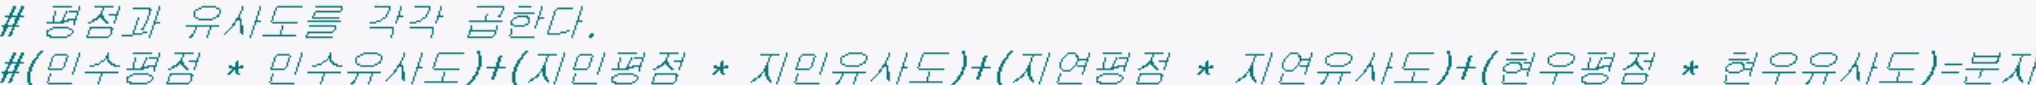

In [34]:
# 분자
nominator = sum(neighbors_ratings * neighbors_similarity)
nominator

12.16496376725352

In [35]:
# 분모
denominator = sum(neighbors_similarity)
denominator

3.3134748798018654

In [36]:
# 민지의 예측 평점
score = nominator/denominator
score

3.671361398092429

### 예측 함수 구현

In [37]:
#특정한 사용자의 책에 대한 평점을 예측하는 함수
def predict_ratings(user_name, book_name):

    # 노인과바다에 대한 민지의 평점을 알고싶다
    # 일단 자기자신은 제외시켜야 한다
    # 본인을 제외한 다름사람의 노인과바다에 대한 평점을 받아본다.
    neighbors_ratings=ratings[book_name].drop(index=user_name)
    neighbors_similarity=similarity_table[user_name].drop(index=user_name)

    # 평점과 유사도를 각각 곱한다.
    #(민수평점 * 민수유사도)+(지민평점 * 지민유사도)+(지연평점 * 지연유사도)+(현우평점 * 현우유사도)=분자
    nominator = (neighbors_ratings * neighbors_similarity).sum()

    #분모 = 나를 제외한 유사도의 합(내가 포함되면 유사도가 1...)
    denominator = neighbors_similarity.sum()

    #민지의 예측평점
    score = nominator / denominator
    return score

In [38]:
predict_ratings('민지','노인과바다')

3.671361398092429

In [39]:
predict_ratings('민수','흥부전')

2.7543750620420546

In [40]:
predict_ratings('현우','백설공주')

2.4607597343308854

In [41]:
ratings

책,노인과바다,백설공주,신데렐라,어린왕자,콩쥐팥쥐,흥부전
사람,,,,,,
민수,3.0,4.0,4.0,3.0,4.0,NaN
민지,NaN,5.0,4.0,1.0,NaN,3.0
지민,4.0,1.0,NaN,5.0,2.0,3.0
지연,5.0,NaN,3.0,4.0,3.0,3.0
현우,3.0,NaN,2.0,NaN,1.0,2.0


### 모든 사용자와 상품에 대한 전체적인 평점 검색

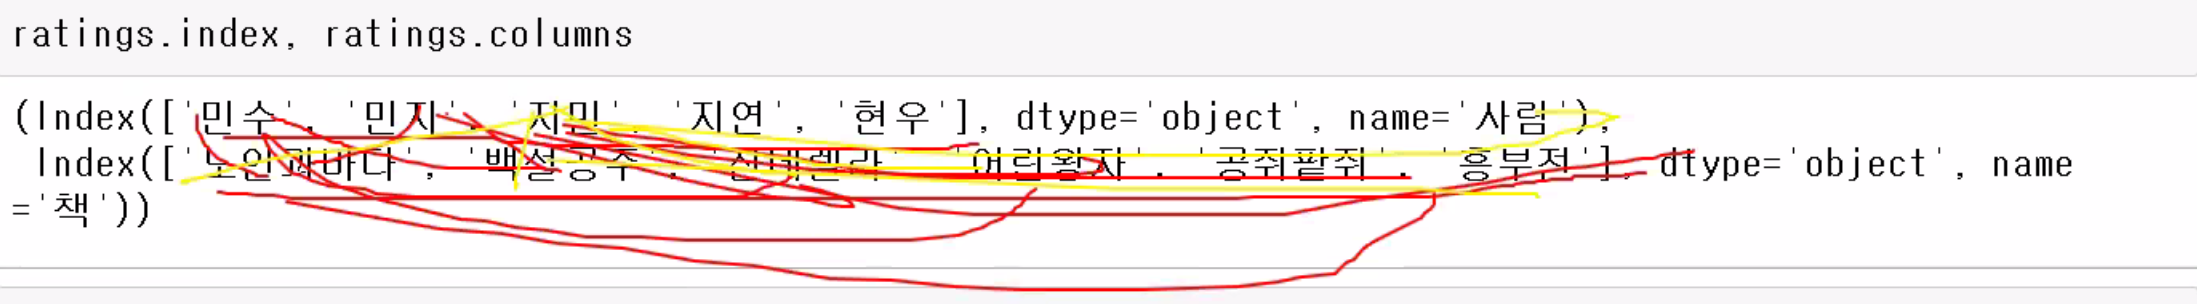

In [42]:
ratings.index, ratings.columns

(Index(['민수', '민지', '지민', '지연', '현우'], dtype='object', name='사람'),
 Index(['노인과바다', '백설공주', '신데렐라', '어린왕자', '콩쥐팥쥐', '흥부전'], dtype='object', name='책'))

In [43]:
ratings_combinations = list(product(ratings.index, ratings.columns))
ratings_combinations

[('민수', '노인과바다'),
 ('민수', '백설공주'),
 ('민수', '신데렐라'),
 ('민수', '어린왕자'),
 ('민수', '콩쥐팥쥐'),
 ('민수', '흥부전'),
 ('민지', '노인과바다'),
 ('민지', '백설공주'),
 ('민지', '신데렐라'),
 ('민지', '어린왕자'),
 ('민지', '콩쥐팥쥐'),
 ('민지', '흥부전'),
 ('지민', '노인과바다'),
 ('지민', '백설공주'),
 ('지민', '신데렐라'),
 ('지민', '어린왕자'),
 ('지민', '콩쥐팥쥐'),
 ('지민', '흥부전'),
 ('지연', '노인과바다'),
 ('지연', '백설공주'),
 ('지연', '신데렐라'),
 ('지연', '어린왕자'),
 ('지연', '콩쥐팥쥐'),
 ('지연', '흥부전'),
 ('현우', '노인과바다'),
 ('현우', '백설공주'),
 ('현우', '신데렐라'),
 ('현우', '어린왕자'),
 ('현우', '콩쥐팥쥐'),
 ('현우', '흥부전')]

In [44]:
rating_list = []

for user_name , book_name in ratings_combinations:
    score = predict_ratings(user_name, book_name)
    
    rating_predict = { # json형대로 만들어서 리스트에 넣어준다.
        'user' : user_name,
        'book' : book_name,
        'score' : score
    }
    
    rating_list.append(rating_predict)
    

In [45]:
rating_list = pd.DataFrame(rating_list)
rating_list

,user,book,score
0,민수,노인과바다,2.964046
1,민수,백설공주,1.544704
2,민수,신데렐라,2.334094
3,민수,어린왕자,2.455289
4,민수,콩쥐팥쥐,1.490775
5,민수,흥부전,2.754375
6,민지,노인과바다,3.671361
7,민지,백설공주,1.298385
8,민지,신데렐라,2.493374
9,민지,어린왕자,2.685136


In [46]:
ratings

책,노인과바다,백설공주,신데렐라,어린왕자,콩쥐팥쥐,흥부전
사람,,,,,,
민수,3.0,4.0,4.0,3.0,4.0,NaN
민지,NaN,5.0,4.0,1.0,NaN,3.0
지민,4.0,1.0,NaN,5.0,2.0,3.0
지연,5.0,NaN,3.0,4.0,3.0,3.0
현우,3.0,NaN,2.0,NaN,1.0,2.0


In [47]:
rating_table = pd.pivot_table(data= rating_list, index='user', columns='book', values='score')

# 추천 알고리즘을 베이스로한 테이블이다.
rating_table

book,노인과바다,백설공주,신데렐라,어린왕자,콩쥐팥쥐,흥부전
user,,,,,,
민수,2.964046,1.544704,2.334094,2.455289,1.490775,2.754375
민지,3.671361,1.298385,2.493374,2.685136,2.522275,1.850321
지민,3.096369,1.795672,3.109381,2.070415,2.157241,1.967154
지연,2.585490,2.392236,2.431305,2.283870,1.790005,1.983205
현우,2.995806,2.460760,2.710577,3.256756,2.196302,2.315152


### 문제 [1] 민지에게 가장 추천하고 싶은책은?

In [48]:
rating_table.loc[user_name].sort_values(ascending=False)

book
어린왕자     3.256756
노인과바다    2.995806
신데렐라     2.710577
백설공주     2.460760
흥부전      2.315152
콩쥐팥쥐     2.196302
Name: 현우, dtype: float64

In [49]:
#특정한 사용자의 추천책을 하나만 골라주는 함수
def recomend_book(user_name):
    #score_best = sorted(rating_table.loc[user_name],reverse=True)[0]
    predict_list = rating_table.loc[user_name].sort_values(ascending=False)
    predict_list = predict_list.head(1).index
    return predict_list

In [50]:
recomend_book('민지')

Index(['노인과바다'], dtype='object', name='book')

In [51]:
def recommand(user_name, n=1):
    return rating_table.loc[user_name].sort_values(ascending=False).index[:n]
recommand('민지', n=1)

Index(['노인과바다'], dtype='object', name='book')

In [52]:
#특정한 사용자의 추천책을 여러개 골라주는 함수 k 값을 넣어서 갯수를 지정해야한다.
def recomend_book(user_name, k=1):
    #score_bset = sorted(rating_table.loc[user_name],reverse=True)[0]
    predict_list = rating_table.loc[user_name].sort_values(ascending=False)
    predict_list = predict_list.head(k).index
    return predict_list
recomend_book('민지',k=2)

Index(['노인과바다', '어린왕자'], dtype='object', name='book')

### 문제 [2] '백설공주' 책에 가장 관심이 있을거 같은 사용자는?

In [53]:
def inter_user(book_name, k=1):
    predict_list = rating_table[book_name].sort_values(ascending=False)
    predict_list = predict_list.head(k).index
    return predict_list
inter_user('백설공주', k=2)

Index(['현우', '지연'], dtype='object', name='user')